In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from numpy import zeros, ones
from numpy.random import randn, randint
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Conv2DTranspose, LeakyReLU
from keras.layers import BatchNormalization, Dropout, Reshape, Flatten

In [2]:
# Define the directory of your images on Kaggle
dataset_dir = "Celebrity_Faces_Dataset" 

# Get a list of all image paths in the directory
image_paths = glob.glob(os.path.join(dataset_dir, '*.jpg'))

# Considering only the first 20,000 images
image_paths = image_paths[:20000]

# Create a function to open, crop and resize images
def load_and_preprocess_real_images(image_path, target_size=(64, 64)):
    # Open the image
    img = Image.open(image_path)
    # Crop 20 pixels from the top and bottom to make it square
    img = img.crop((0, 20, 178, 198))
    # Resize the image
    img = img.resize(target_size)
    # Convert to numpy array and scale to [-1, 1]
    img = np.array(img)/127.5 - 1
    return img

# Open, crop and resize all images
dataset = np.array([load_and_preprocess_real_images(img_path) for img_path in image_paths])

# Print dataset shape
print(dataset.shape)

(20000, 64, 64, 3)


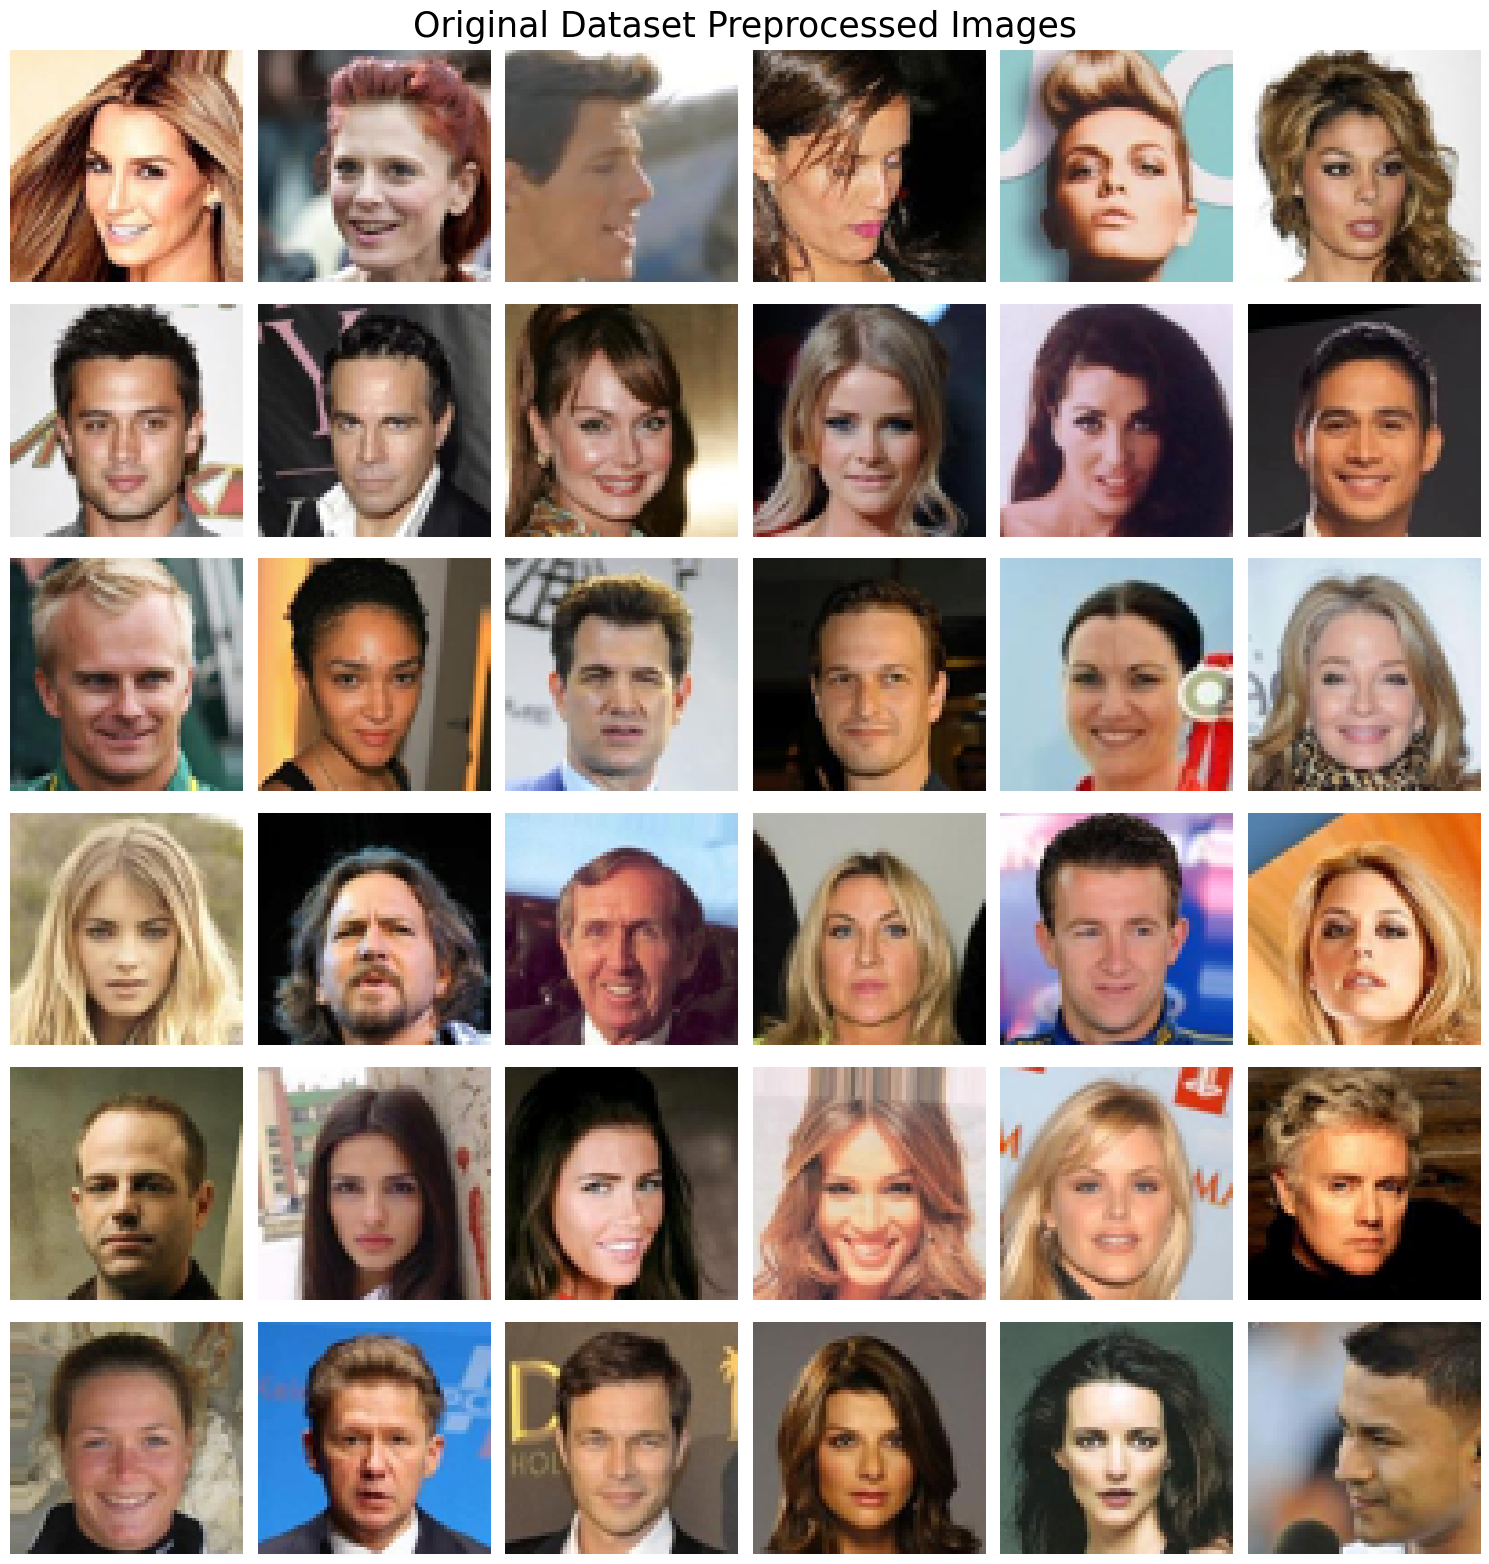

In [3]:
# Create a subplot for the first 25 images
fig, axes = plt.subplots(6, 6, figsize=(15, 16))

for i, ax in enumerate(axes.flat):
    # Get the i-th image
    img = dataset[i]
    # Rescale the image to [0, 1] for plotting
    img_rescaled = (img + 1) / 2
    # Plot the image on the i-th subplot
    ax.imshow(img_rescaled)
    ax.axis('off')

# Add a super title
fig.suptitle('Original Dataset Preprocessed Images', fontsize=25)

plt.tight_layout()
plt.show()

In [5]:
def build_discriminator(image_shape=(64, 64, 3)):
    model = Sequential()
    
    # Initial convolutional layer
    model.add(Conv2D(128, (3, 3), strides=(2,2), padding='same', input_shape=image_shape))
    model.add(LeakyReLU(0.2))
    
    # Second convolutional layer
    model.add(Conv2D(128, (3, 3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Third convolutional layer
    model.add(Conv2D(256, (3, 3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Fourth convolutional layer
    model.add(Conv2D(256, (3, 3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Fifth convolutional layer
    model.add(Conv2D(512, (3, 3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(0.2))

    # Flatten and dense layer for classification
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    # Define optimizer and compile model
    optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

# Build and display discriminator summary
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 4, 4, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 2, 2, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,218,625 (8.46 MB)

 Trainable params: 2,218,625 (8.46 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
def build_generator(latent_dim, channels=3):
    model = Sequential()
    
    # Initial dense layer
    model.add(Dense(16 * 16 * 128, input_dim=latent_dim))
    model.add(LeakyReLU(0.2))
    
    # Reshape to (16, 16, 128) tensor for convolutional layers
    model.add(Reshape((16, 16, 128)))
    
    # First deconvolutional layer
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Second deconvolutional layer
    model.add(Conv2DTranspose(128, (4, 4), strides=(1, 1), padding='same'))
    model.add(LeakyReLU(0.2))  
    
    # Third deconvolutional layer
    model.add(Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(0.2))  
    
    # Fourth deconvolutional layer
    model.add(Conv2DTranspose(64, (4, 4), strides=(1, 1), padding='same'))
    model.add(LeakyReLU(0.2))  
    
    # Output convolutional layer with 'tanh' activation
    model.add(Conv2D(channels, (8, 8), activation='tanh', padding='same'))
    
    return model

# Build and display generator summary
generator = build_generator(100)
generator.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 32768)          │     3,309,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 32, 32, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 64)     │       131,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 64, 64, 64)     │        65,600 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 64, 64, 3)      │        12,291 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,043,139 (15.42 MB)

 Trainable params: 4,043,139 (15.42 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
def build_gan(generator, discriminator):
    
    # Setting discriminator as non-trainable, so its weights won't update when training the GAN
    discriminator.trainable = False

    # Creating the GAN model
    model = Sequential()
    
    # Adding the generator
    model.add(generator)
    
    # Adding the discriminator
    model.add(discriminator)

    # Compiling the GAN model
    optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

In [8]:
def generate_real_samples(dataset, num_samples):
    sample_indices = randint(0, dataset.shape[0], num_samples)
    X = dataset[sample_indices]
    y = ones((num_samples, 1))
    return X, y

In [9]:
def generate_noise_samples(num_samples, noise_dim):
    X_noise = randn(noise_dim * num_samples)
    X_noise = X_noise.reshape(num_samples, noise_dim)
    return X_noise 

In [10]:
def generate_fake_samples(generator, noise_dim, num_samples):
    X_noise = generate_noise_samples(num_samples, noise_dim)
    X = generator.predict(X_noise)
    y = zeros((num_samples, 1 ))
    return X, y

In [11]:
def generate_images(epoch, generator, num_samples=6, noise_dim=100):
    """
    Generate images from the generator model for a given epoch.
    """
    # Generate noise samples
    X_noise = generate_noise_samples(num_samples, noise_dim)
    
    # Use generator to produce images from noise
    X = generator.predict(X_noise, verbose=0)

    # Rescale images to [0, 1] for visualization
    X = (X + 1) / 2

    return X

In [12]:
def display_saved_images(saved_images, display_frequency):
    """
    Display the saved generated images after training.
    """
    for epoch, images in enumerate(saved_images):
        fig, axes = plt.subplots(1, len(images), figsize=(15, 3))
        for i, img in enumerate(images):
            axes[i].imshow(img)
            axes[i].axis('off')
        fig.suptitle(f"Generated Images at Epoch {epoch*display_frequency + 1}", fontsize=22)
        plt.tight_layout()
        plt.show()

In [13]:
def plot_generated_images(epoch, generator, num_samples=6, noise_dim=100, figsize=(15, 3)):
    """
    Plot and visualize generated images from the generator model for a given epoch.
    """
    
    # Generate noise samples
    X_noise = generate_noise_samples(num_samples, noise_dim)
    
    # Use generator to produce images from noise
    X = generator.predict(X_noise, verbose=0)

    # Rescale images to [0, 1] for visualization
    X = (X + 1) / 2

    # Plotting the images
    fig, axes = plt.subplots(1, num_samples, figsize=figsize)

    for i in range(num_samples):
        axes[i].imshow(X[i])
        axes[i].axis('off')

    # Add a descriptive title
    fig.suptitle(f"Generated Images at Epoch {epoch+1}", fontsize=22)
    plt.tight_layout()
    plt.show()

In [14]:
def train(generator_model, discriminator_model, gan_model, dataset, noise_dimension,
          num_epochs=100, batch_size=128, display_frequency=10, verbose=1):
    
    # Create an empty list to store generated images for each epoch
    saved_images_for_epochs = []
    
    # Calculate the number of batches per epoch
    batches_per_epoch = int(dataset.shape[0] / batch_size)
    
    # Calculate half the size of a batch
    half_batch_size   = int(batch_size / 2)

    # Loop over all epochs
    for epoch in range(num_epochs):
        # Loop over all batches within this epoch
        for batch_num in range(batches_per_epoch):
            
            # Generate a batch of real images and their corresponding labels
            real_images, real_labels    = generate_real_samples(dataset, half_batch_size)
            # Train the discriminator on the real images and calculate loss and accuracy
            dsr_loss_real, dsr_acc_real = discriminator_model.train_on_batch(real_images, real_labels)

            # Generate a batch of fake images and their corresponding labels
            fake_images, fake_labels    = generate_fake_samples(generator_model, noise_dimension, half_batch_size)
            # Train the discriminator on the fake images and calculate loss and accuracy
            dsr_loss_fake, dsr_acc_fake = discriminator_model.train_on_batch(fake_images, fake_labels)
            
            # Calculate the average discriminator loss and accuracy over real and fake images
            dsr_loss = 0.5 * np.add(dsr_loss_real, dsr_loss_fake)
            dsr_acc  = 0.5 * np.add(dsr_acc_real, dsr_acc_fake)
            
            # Generate noise samples and their corresponding labels for training the generator
            gan_noise  = generate_noise_samples(batch_size, noise_dimension)
            gan_labels = np.ones((batch_size, 1))
            
            # Train the generator and calculate loss
            gen_loss, _ = gan_model.train_on_batch(gan_noise, gan_labels)
            
            if verbose:  # This condition checks if verbose is non-zero
                # Print training information for this batch
                print(f"[ Epoch: {epoch+1} , Batch: {batch_num+1} ] --> [ Discriminator Loss : {dsr_loss:.6f} , Discriminator Accuracy: {100*dsr_acc:.2f}% ] [ Generator Loss: {gen_loss:.6f} ]")
                     
        # Display generated images at the specified frequency
        if epoch % display_frequency == 0:
            generated_images_for_epoch = generate_images(epoch, generator_model)
            saved_images_for_epochs.append(generated_images_for_epoch)
            
            # Plot generated images to visualize the progress of the generator
            plot_generated_images(epoch, generator_model)

    # Due to constraints on Kaggle output file size, saving the model is commented out.
    # generator_model.save('Photorealistic_Face_Generator.h5')
    
    return saved_images_for_epochs

In [15]:
# Set noise dimension for generator input
noise_dimension = 100

# Build discriminator model
discriminator = build_discriminator()

# Build generator model
generator = build_generator(noise_dimension)

# Combine generator and discriminator to form the GAN model
gan_model = build_gan(generator, discriminator)

# Train the GAN model on the dataset and get the saved images list
saved_images = train(generator, discriminator, gan_model, dataset, noise_dimension, num_epochs=251, batch_size=128, display_frequency=50, verbose=0)

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step


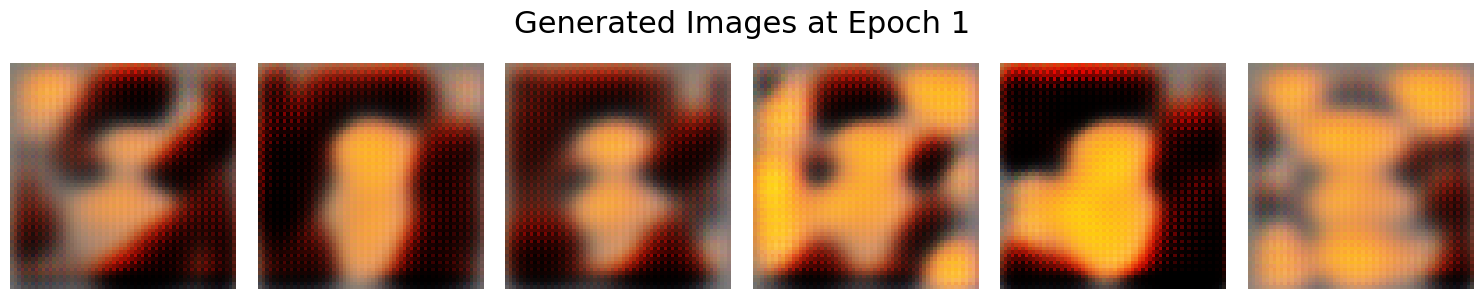

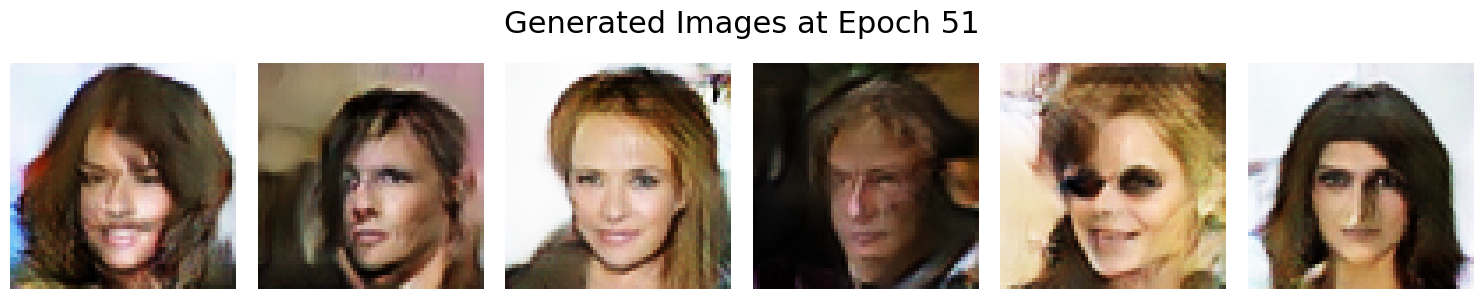

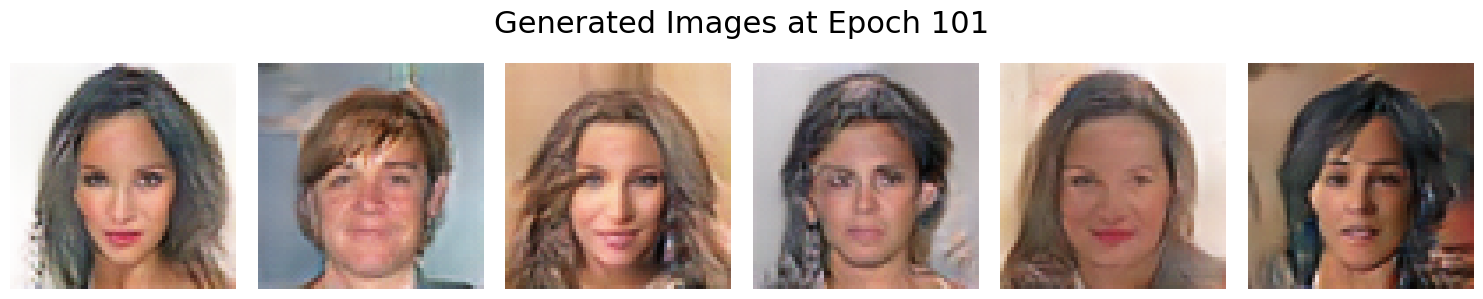

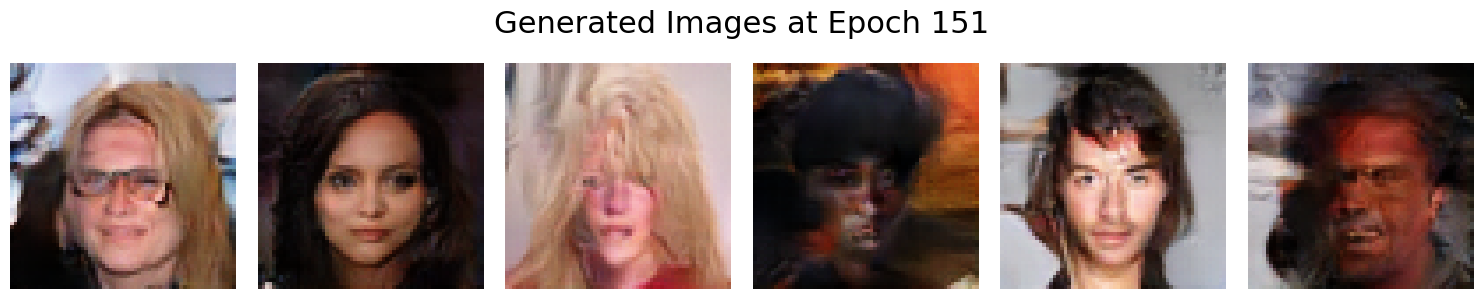

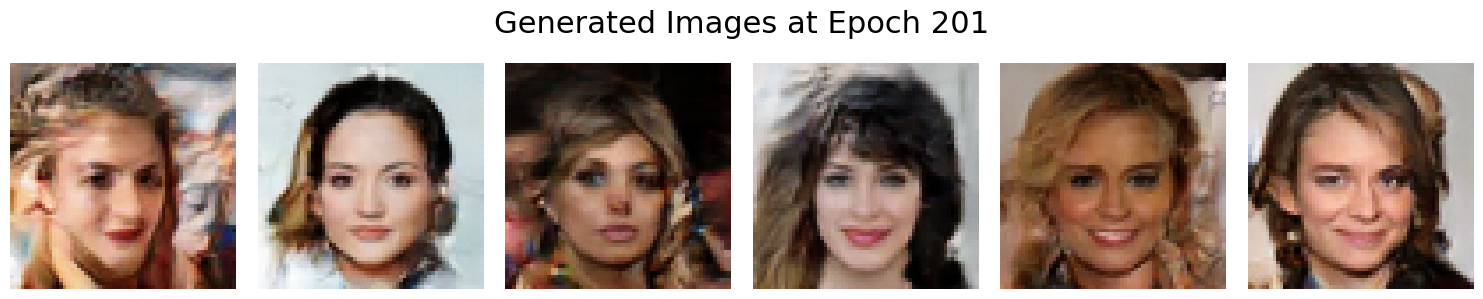

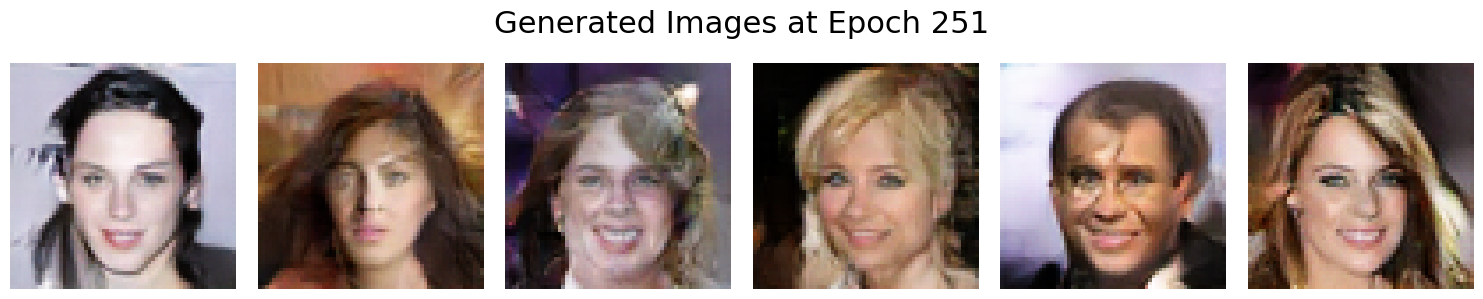

In [15]:
# Display all the saved images during 
display_saved_images(saved_images, display_frequency=50)

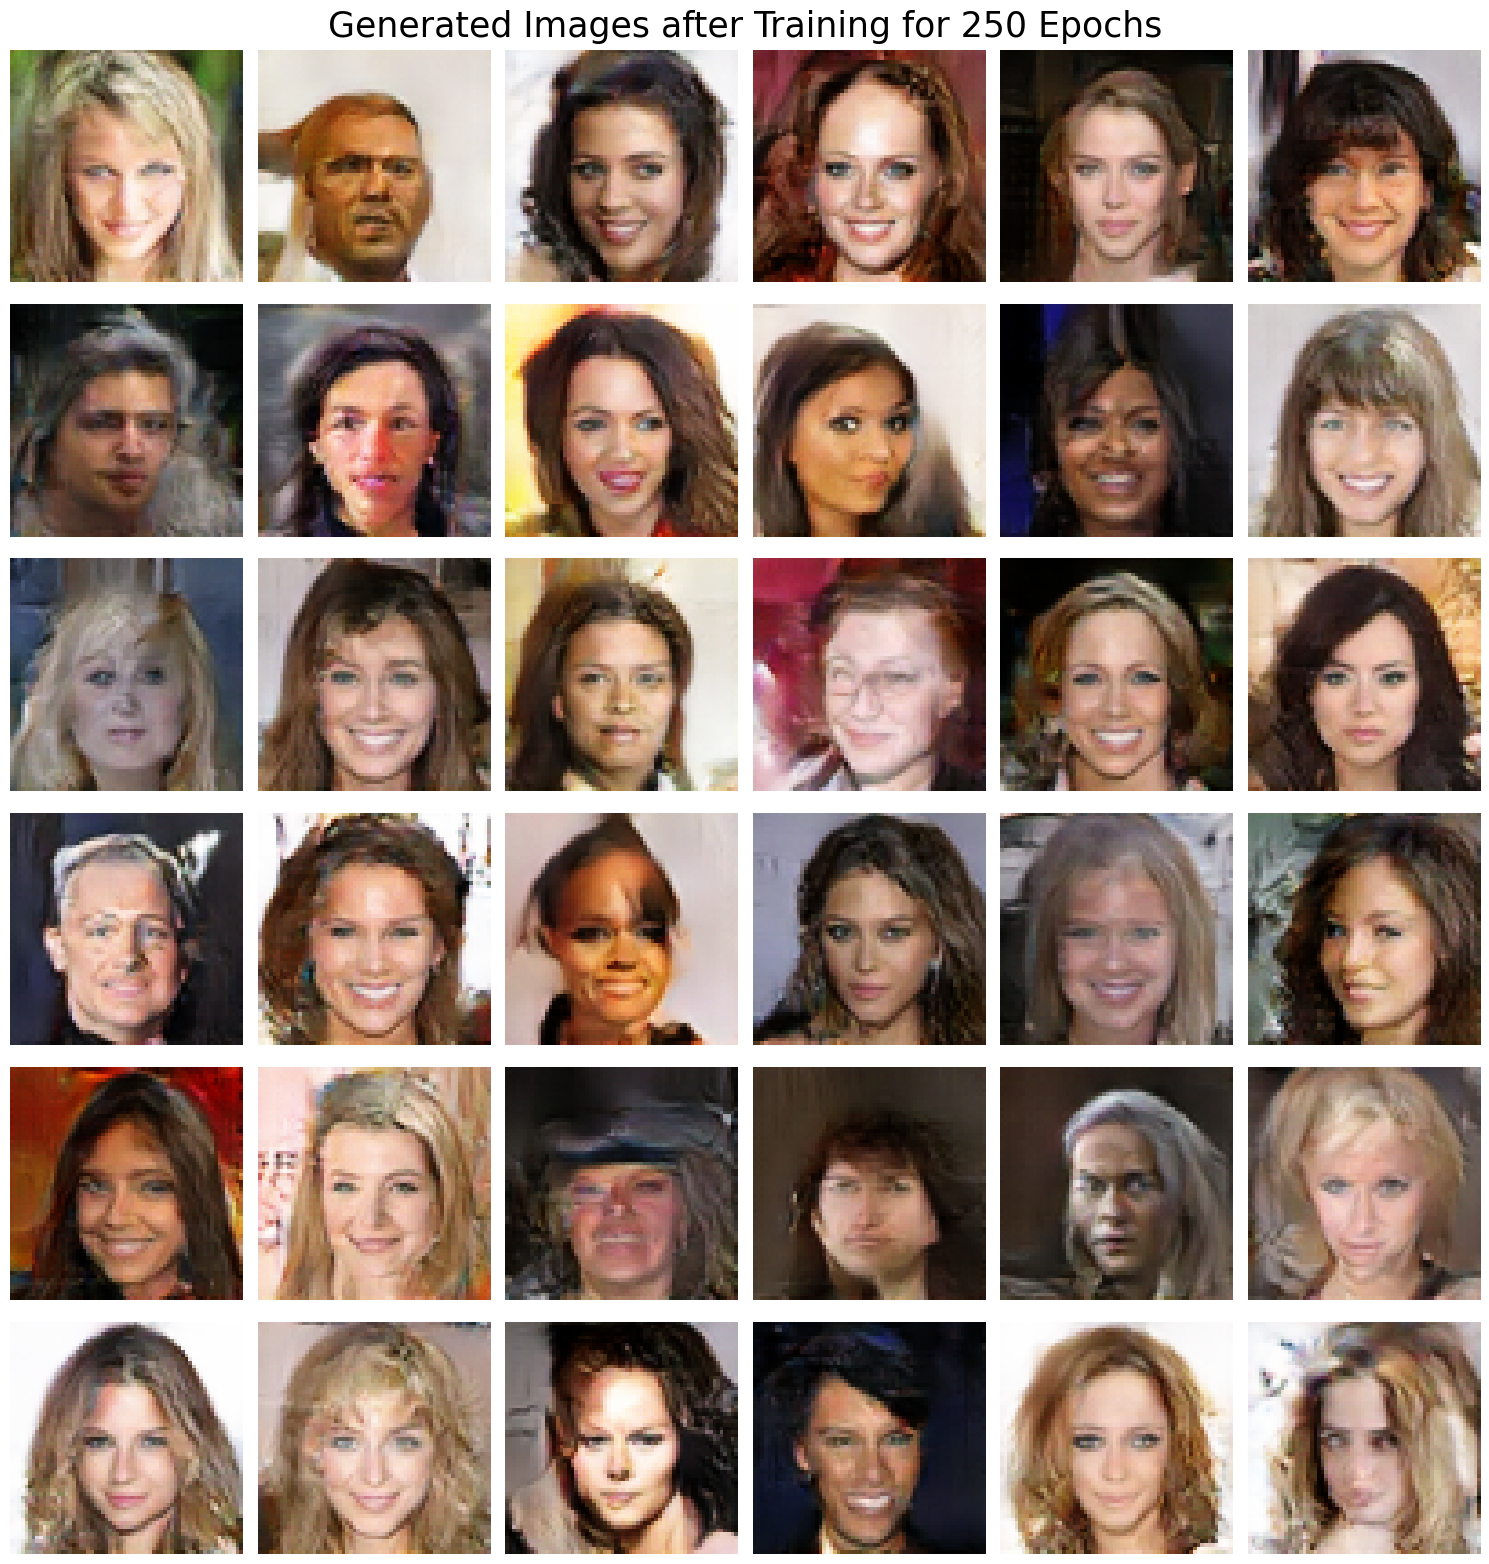

In [16]:
def plot_generated_images_after_training(generator, noise_dim=100, figsize=(15, 16)):
    
    fig, axes = plt.subplots(6, 6, figsize=figsize)
    
    for i, ax in enumerate(axes.flat):
        # Generate noise samples
        X_noise = generate_noise_samples(1, noise_dim)
        
        # Use generator to create an image
        X = generator.predict(X_noise, verbose=0)
        
        # Rescale images to [0, 1] for plotting
        X = (X + 1) / 2
        
        # Plot the image on the i-th subplot
        ax.imshow(X[0])
        ax.axis('off')

    # Add a super title
    fig.suptitle('Generated Images after Training for 250 Epochs', fontsize=25)
    
    plt.tight_layout()
    plt.show()

# Call the function
plot_generated_images_after_training(generator)